# Training a digit-classification neural network on the MNIST dataset using Keras

The MNIST dataset is one of the most popular benchmark-datasets in modern machine learning. The dataset consists of 70000 images of handwritten digits and associated labels, which can be used to train neural network performing image classification.

The following program presents the basic workflow of Keras showing the most import details of the API.

In [1]:
from os import environ
environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 8       # Training batch size
epochs      = 120       # Number of epochs
num_classes = 2        # Number of classes

# input image dimensions
img_rows, img_cols = 256, 256
vgg16_shape = 224      # Shape of VGG16 input image, (224X224X3)

mapping_csv = '../Data/mapping.csv'       # Name of the mapping.csv

## Read the data

The code below read the dataset with the help of the mapping.csv file. The mapping.csv contains two columns, one is the image name and the other is the corresponding class ("alpha": 0, "beta": 1, "muon": 2).

In [3]:
from keras.utils.np_utils import to_categorical
import cv2

image_id, image_class = np.loadtxt(mapping_csv, delimiter=',', dtype={'names': ('image_id', 'image_class'),
          'formats': ('|S100', np.float)}, unpack=True)

#print image_id
X = []
for img_name in image_id:
    img = plt.imread('' + '../' + img_name)
    img = img[:,:,:3]
    X.append(img)
X = np.array(X)    # Convert list to array
y = image_class

# Convert digits to one-hot vectors, e.g.,
# 2 -> [0 0 1 0 0 0 0 0 0 0]
# 0 -> [1 0 0 0 0 0 0 0 0 0]
# 9 -> [0 0 0 0 0 0 0 0 0 1]
dummy_y = to_categorical(y)

Using TensorFlow backend.


Display some input images.

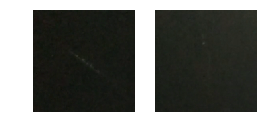

In [4]:
num_examples = 2
plt.figure(figsize=(num_examples*2, 2))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.axis('off')
    example = np.squeeze(np.array(X[i]*255).astype("uint8"))
    plt.imshow(example, cmap="gray")

Resize the image such that it fits the VGG16 input shape (224X224X3)

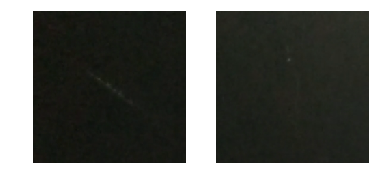

In [5]:
# Resize the input image to the VGG16 input image shape (224X224X3)
image = []
for i in range(0, X.shape[0]):
    a = np.squeeze(cv2.resize(X[i], (vgg16_shape, vgg16_shape), interpolation=cv2.INTER_LINEAR)*255).astype(int)
    #a = a[:,:,:3] # Drop out alpha channel of png
    image.append(a)
X = np.array(image)
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.axis('off')
    example = X[i]
    plt.imshow(example, cmap="gray")

Preprocess the input and  split the data into training and validation set

In [6]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
dummy_y = dummy_y[indices]

test_size = 0.7
split = int(test_size * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = dummy_y[:split]
y_test = dummy_y[split:]

## Define the model

The model definition in Keras can be done using the `Sequential` or the functional API. Shown here is the `Sequential` API allowing to stack neural network layers on top of each other, which is feasible for most neural network models. In contrast, the functional API would allow to have multiple inputs and outputs for a maximum of flexibility to build your custom model.

In [7]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import InputLayer, Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(vgg16_shape, vgg16_shape, 3))    # include_top=False to remove the top layer

X_train = base_model.predict(X_train)
X_test = base_model.predict(X_test)
X_train.shape, X_test.shape

model_inputshape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

X_train = X_train.reshape(X_train.shape[0], model_inputshape) # Converting to 1-D
X_test = X_test.reshape(X_test.shape[0], model_inputshape)

train = X_train/X_train.max()      # centering the data
X_test = X_test/X_train.max()

Build our own model

In [8]:
model = Sequential()
model.add(InputLayer((model_inputshape,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(num_classes, activation='softmax'))    # output layer

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 25,693,186
Trainable params: 25,693,186
Non-trainable params: 0
_________________________________________________________________


## Compile the model

Using Keras, you have to `compile` a model, which means adding the loss function, the optimizer algorithm and validation metrics to your training setup.

In [9]:
model.compile(loss="categorical_crossentropy",
        optimizer=Adam(lr=lr_init),
        metrics=["accuracy"])

## Train the model

The cell below shows the training procedure of Keras using the `model.fit(...)` method. Besides typical options such as `batch_size` and `epochs`, which control the number of gradient steps of your training, Keras allows to use callbacks during training.

Callbacks are methods, which are called during training to perform tasks such as saving checkpoints of the model (`ModelCheckpoint`) or stop the training early if a convergence criteria is met (`EarlyStopping`).

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
            filepath="ccAI_model.h5",
            save_best_only=True,
            verbose=1)
early_stopping = EarlyStopping(patience=5)

history = model.fit(train, y_train, # Training data
            batch_size=batch_size, # Batch size
            epochs=epochs, # Maximum number of training epochs
            validation_split=0.5, # Use 50% of the train dataset for validation
            callbacks=[checkpoint, early_stopping]) # Register callbacks

Train on 26 samples, validate on 27 samples
Epoch 1/120
26/26 [==============================] - 2s 69ms/step - loss: 1.3759 - acc: 0.5000 - val_loss: 0.6008 - val_acc: 0.8519

Epoch 00001: val_loss improved from inf to 0.60084, saving model to ccAI_model.h5
Epoch 2/120
26/26 [==============================] - 1s 38ms/step - loss: 1.0130 - acc: 0.5769 - val_loss: 0.6168 - val_acc: 0.5185

Epoch 00002: val_loss did not improve from 0.60084
Epoch 3/120
26/26 [==============================] - 1s 37ms/step - loss: 0.7417 - acc: 0.4615 - val_loss: 0.8868 - val_acc: 0.5185

Epoch 00003: val_loss did not improve from 0.60084
Epoch 4/120
26/26 [==============================] - 1s 37ms/step - loss: 0.6223 - acc: 0.5769 - val_loss: 0.4985 - val_acc: 0.7407

Epoch 00004: val_loss improved from 0.60084 to 0.49853, saving model to ccAI_model.h5
Epoch 5/120
26/26 [==============================] - 1s 39ms/step - loss: 0.4106 - acc: 0.7692 - val_loss: 0.3932 - val_acc: 0.8519

Epoch 00005: val_loss


Epoch 00041: val_loss did not improve from 0.24064
Epoch 42/120
26/26 [==============================] - 1s 39ms/step - loss: 0.1454 - acc: 0.9615 - val_loss: 0.3184 - val_acc: 0.9259

Epoch 00042: val_loss did not improve from 0.24064
Epoch 43/120
26/26 [==============================] - 1s 42ms/step - loss: 0.1913 - acc: 0.9615 - val_loss: 0.2724 - val_acc: 0.8889

Epoch 00043: val_loss did not improve from 0.24064
Epoch 44/120
26/26 [==============================] - 1s 39ms/step - loss: 0.1024 - acc: 0.9615 - val_loss: 0.4188 - val_acc: 0.8519

Epoch 00044: val_loss did not improve from 0.24064


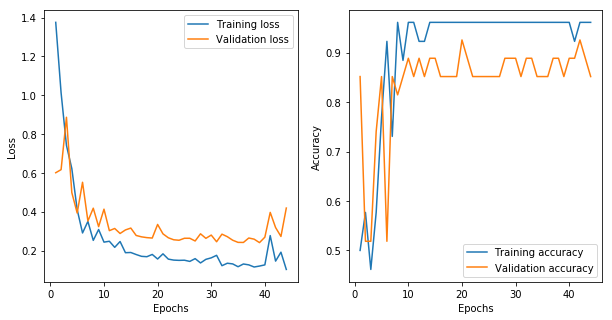

In [11]:
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["loss"], label="Training loss")
plt.plot(epochs, history.history["val_loss"], label="Validation loss")
plt.legend(), plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["acc"], label="Training accuracy")
plt.plot(epochs, history.history["val_acc"], label="Validation accuracy")
plt.legend(), plt.xlabel("Epochs"), plt.ylabel("Accuracy");

## Test the model

The prediction of unseen data is performed using the `model.predict(inputs)` call. Below, a basic test of the model is done by calculating the accuracy on the test dataset.

In [12]:
# Get predictions on test dataset
y_pred = model.predict(X_test)

# Compare predictions with ground truth
test_accuracy = np.sum(
        np.argmax(y_test, axis=1)==np.argmax(y_pred, axis=1))/float(X_test.shape[0])

print("Test accuracy: {}".format(test_accuracy))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test accuracy: 0.95652173913
('Test loss:', 0.4123896360397339)
('Test accuracy:', 0.95652174949646)
